# Project 2: Oil Price Prediction

### Step 1: Load the dataset, Change type of columns, Handle missing values and Plot each column's time series graph

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [8]:
df = pd.read_csv('brent_oil_weekly_30_years.csv')
print(df.dtypes)
print()
print(df.isna().sum())
df.describe()

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        1
Change %    0
dtype: int64


,Price,Open,High,Low
count,1566.000000,1566.00000,1566.000000,1566.000000
mean,55.154898,55.11825,56.846424,53.234036
std,32.946323,32.94124,33.770655,31.957943
min,9.820000,9.95000,10.280000,9.550000
25%,24.755000,24.85000,25.595000,23.840000
50%,52.470000,52.47000,54.180000,50.445000
75%,76.760000,76.85750,78.902500,74.352500
max,144.490000,144.40000,147.500000,139.540000


In [9]:
class PreProcessData:
    def __init__(self, df) -> None:
        self.df = df
        
    def convert_date(self, col):
        self.df[col] = pd.to_datetime(self.df[col])

    def convert_vol_to_int(self, value):
        if type(value) != str or pd.isna(value):
            return value
        elif value.endswith('K'):
            return float(value[:-1]) * 1000
        elif value.endswith('M'):
            return float(value[:-1]) * 1000000
        return float(value)

    def convert_change_to_int(self, value):
        if type(value) != str or pd.isna(value):
            return value
        return float(value[:-1])

    def handle_missing_values(self, col):
        mean = self.df[col].mean()
        self.df[col] = self.df[col].fillna(mean)
    
    def train_test_split(self):
        train_data = self.df[self.df['Date'] < '2019-01-01']
        test_data = self.df[self.df['Date'] >= '2019-01-01']
        train_data = train_data.reset_index(drop=True)
        return train_data, test_data


data_preprocessing = PreProcessData(df)

In [10]:
data_preprocessing.convert_date('Date')
df['Vol.'] = df['Vol.'].apply(data_preprocessing.convert_vol_to_int)
df['Change %'] = df['Change %'].apply(data_preprocessing.convert_change_to_int)
data_preprocessing.handle_missing_values('Vol.')


In [11]:
print(df.dtypes)
print()
print(df.isna().sum())
df

Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Vol.               float64
Change %           float64
dtype: object

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


,Date,Price,Open,High,Low,Vol.,Change %
0,2023-04-09,84.46,85.23,85.52,84.11,6.014990e+05,-0.78
1,2023-04-02,85.12,86.00,86.44,83.50,1.290000e+06,6.55
2,2023-03-26,79.89,74.62,79.95,74.39,1.680000e+06,6.53
3,2023-03-19,74.99,73.01,77.44,70.12,1.060000e+06,2.77
4,2023-03-12,72.97,82.60,83.48,71.40,2.130000e+06,-11.85
...,...,...,...,...,...,...,...
1561,1993-05-09,18.60,19.25,19.27,18.51,8.964000e+04,-3.07
1562,1993-05-02,19.19,19.25,19.30,18.96,7.882000e+04,0.21
1563,1993-04-25,19.15,18.98,19.24,18.72,6.736000e+04,1.27
1564,1993-04-18,18.91,18.82,18.98,18.71,7.749000e+04,0.53


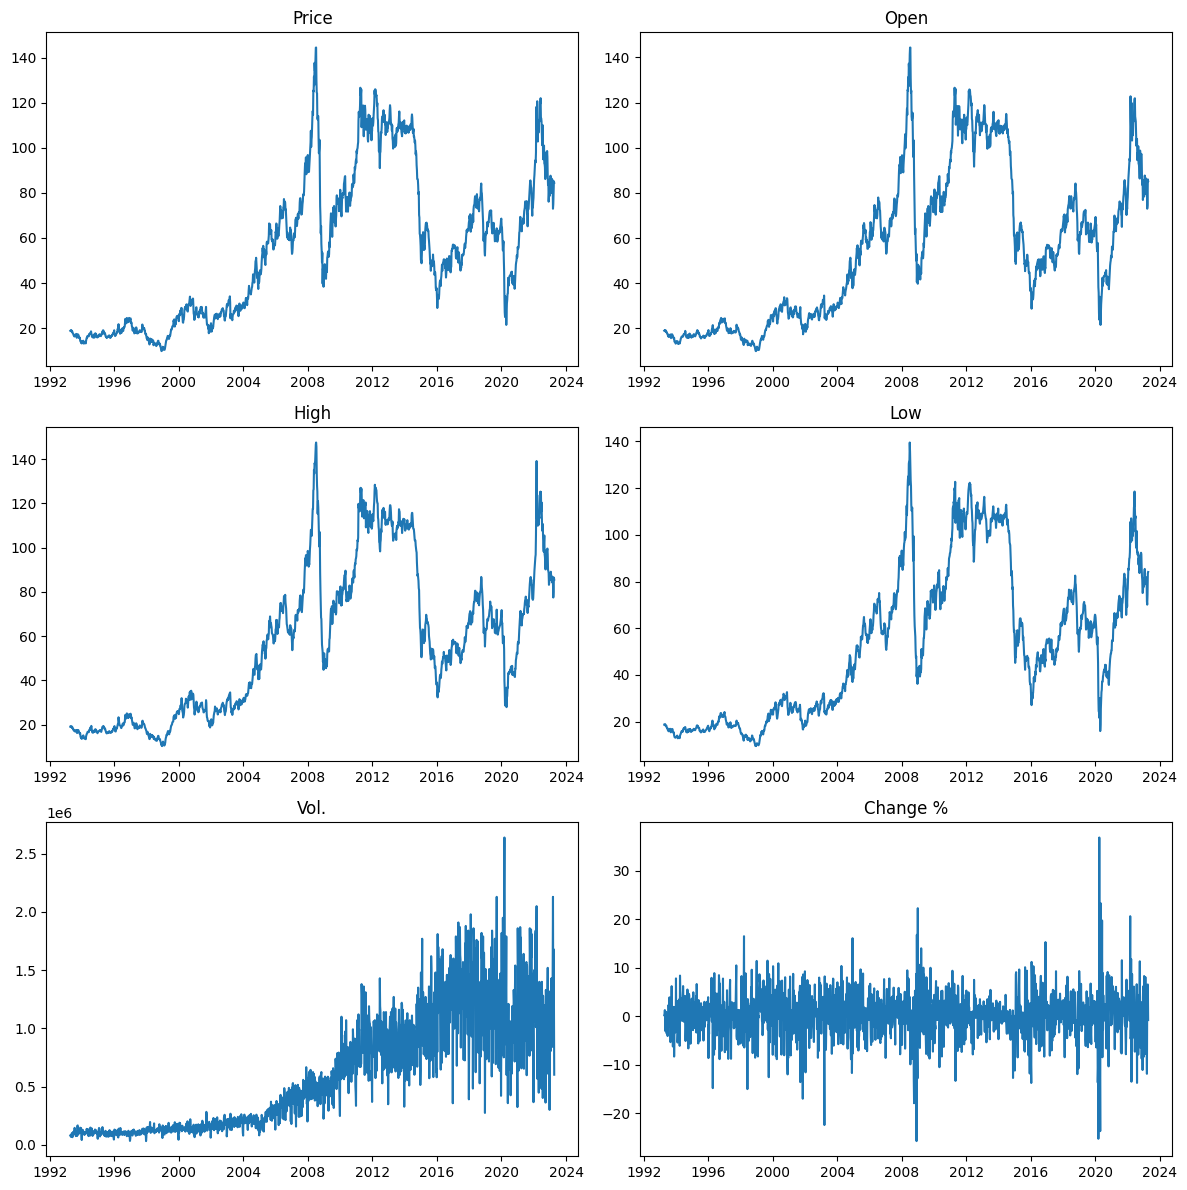

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

for i, col in enumerate(df.drop('Date', axis=1).columns):
    ax = axs[i // 2, i % 2]
    ax.plot(df['Date'], df[col])
    ax.set_title(col)
    
plt.tight_layout()    
plt.show()

### Step 2: Write a function to return a new dataframe based on document

In [13]:
def create_time_series_df(df, week_before, week_after):
        new_df = pd.DataFrame()
        for i in range(len(df)):
            new_data = dict()
            current_date = df.iloc[i]['Date']
            new_data['t'] = current_date
            for n in range(week_before):
                for col in df.drop('Date', axis=1).columns:
                    if i + n < len(df):
                        data = df.iloc[i + n]
                        new_data[col + f"_t-{n + 1}"] = data[col]
                    else:
                        new_data[col + f"_t-{n + 1}"] = None
            for m in range(1, week_after + 1):
                col  = 'Price'
                if i - m >= 0:
                    data = df.iloc[i - m]
                    new_data[col + f"_t+{m}"] = data['Price']
                else:
                    new_data[col + f"_t+{m}"] = None
                    
            new_df = pd.concat([new_df, pd.DataFrame(new_data, index=[0])], ignore_index=True)
        return new_df

In [14]:
tmp_df = create_time_series_df(df, week_before=2, week_after=1)
tmp_df

,t,Price_t-1,Open_t-1,High_t-1,Low_t-1,Vol._t-1,Change %_t-1,Price_t-2,Open_t-2,High_t-2,Low_t-2,Vol._t-2,Change %_t-2,Price_t+1
0,2023-04-09,84.46,85.23,85.52,84.11,6.014990e+05,-0.78,85.12,86.00,86.44,83.50,1290000.0,6.55,NaN
1,2023-04-02,85.12,86.00,86.44,83.50,1.290000e+06,6.55,79.89,74.62,79.95,74.39,1680000.0,6.53,84.46
2,2023-03-26,79.89,74.62,79.95,74.39,1.680000e+06,6.53,74.99,73.01,77.44,70.12,1060000.0,2.77,85.12
3,2023-03-19,74.99,73.01,77.44,70.12,1.060000e+06,2.77,72.97,82.60,83.48,71.40,2130000.0,-11.85,79.89
4,2023-03-12,72.97,82.60,83.48,71.40,2.130000e+06,-11.85,82.78,85.83,86.75,80.73,1490000.0,-3.55,74.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1561,1993-05-09,18.60,19.25,19.27,18.51,8.964000e+04,-3.07,19.19,19.25,19.30,18.96,78820.0,0.21,18.43
1562,1993-05-02,19.19,19.25,19.30,18.96,7.882000e+04,0.21,19.15,18.98,19.24,18.72,67360.0,1.27,18.60
1563,1993-04-25,19.15,18.98,19.24,18.72,6.736000e+04,1.27,18.91,18.82,18.98,18.71,77490.0,0.53,19.19
1564,1993-04-18,18.91,18.82,18.98,18.71,7.749000e+04,0.53,18.81,18.98,19.03,18.73,79200.0,0.21,19.15


### Step 3: Split dataset to train and test with the condition of dates less than and greater than 2019

In [15]:
train_data, test_data = data_preprocessing.train_test_split()

In [16]:
train_data

,Date,Price,Open,High,Low,Vol.,Change %
0,2018-12-30,57.06,53.00,58.31,52.51,1010000.0,9.31
1,2018-12-23,52.20,53.49,55.29,49.93,272920.0,-3.01
2,2018-12-16,53.82,60.25,61.21,52.79,1490000.0,-10.72
3,2018-12-09,60.28,61.34,62.33,59.33,1210000.0,-2.25
4,2018-12-02,61.67,59.98,63.73,58.36,1650000.0,5.04
...,...,...,...,...,...,...,...
1338,1993-05-09,18.60,19.25,19.27,18.51,89640.0,-3.07
1339,1993-05-02,19.19,19.25,19.30,18.96,78820.0,0.21
1340,1993-04-25,19.15,18.98,19.24,18.72,67360.0,1.27
1341,1993-04-18,18.91,18.82,18.98,18.71,77490.0,0.53


In [17]:
test_data

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-04-09,84.46,85.23,85.52,84.11,6.014990e+05,-0.78
1,2023-04-02,85.12,86.00,86.44,83.50,1.290000e+06,6.55
2,2023-03-26,79.89,74.62,79.95,74.39,1.680000e+06,6.53
3,2023-03-19,74.99,73.01,77.44,70.12,1.060000e+06,2.77
4,2023-03-12,72.97,82.60,83.48,71.40,2.130000e+06,-11.85
...,...,...,...,...,...,...,...
218,2019-02-03,62.10,62.83,63.63,60.60,1.280000e+06,-1.04
219,2019-01-27,62.75,61.49,62.97,59.49,7.351000e+05,1.80
220,2019-01-20,61.64,62.74,63.15,60.21,1.220000e+06,-1.69
221,2019-01-13,62.70,60.62,63.00,58.90,1.380000e+06,3.67


### Step 4: Create new training set and training the models

In [18]:
# Only consider features about previous 8 weeks and 1 next week of each date
new_train_data = create_time_series_df(train_data, week_before=8, week_after=1)
new_test_data = create_time_series_df(test_data, week_before=8, week_after=1)

In [19]:
#new_train_data
#new_test_data

In [20]:
# Only keep the features of prices of previos weeks and price of the next week of each date
new_columns = [column for column in new_train_data.columns if ('Price' in column) == True]

In [21]:
new_train_data = new_train_data[new_columns]
new_test_data = new_test_data[new_columns]

In [22]:
# Fill NaN cells with mean of their column

new_train_data = new_train_data.fillna(new_train_data.mean())
new_test_data = new_test_data.fillna(new_test_data.mean())

In [23]:
# Scale the datapoints

X_train = new_train_data.iloc[:, :-1]
y_train = new_train_data['Price_t+1']

X_test = new_test_data.iloc[:, :-1]
y_test = new_test_data['Price_t+1']

scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [25]:
# Train lineaer Regression model
linreg = LinearRegression()

linreg.fit(X_train_scaled, y_train)

LinearRegression()

In [26]:
# Evaluate lineaer Regression model
y_pred_lin = linreg.predict(X_test_scaled)
y_truth_lin = y_test

print('MSE:', mean_squared_error(y_pred_lin, y_truth_lin), '\nMAE:', mean_absolute_error(y_pred_lin, y_truth_lin))

MSE: 17.50826429473429 
MAE: 2.937049632152545


In [27]:
# Finding best SVR parameters by suing GridSearchCV
svr = SVR()

'''
parameters = {
    'kernel': ('linear', 'rbf','poly'),
    'C':[1, 10, 100],
    'gamma': [1e-2, 0.1, 0.4, 0.8],
    'epsilon':[1e-2, 0.1, 0.4, 0.8]
}
'''

# After using GridSearchCV, the best parameters are:
# {'C': 100, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'linear'}

#grid_svr = GridSearchCV(svr, parameters, cv=3, verbose=10, n_jobs=-1)
#grid_svr.fit(X_train_scaled, y_train)

"\nparameters = {\n    'kernel': ('linear', 'rbf','poly'),\n    'C':[1, 10, 100],\n    'gamma': [1e-2, 0.1, 0.4, 0.8],\n    'epsilon':[1e-2, 0.1, 0.4, 0.8]\n}\n"

In [28]:
# Training SVR with the best parameters
svr = SVR(C=100, epsilon=0.1, gamma=0.01, kernel='linear')

svr.fit(X_train_scaled, y_train)

SVR(C=100, gamma=0.01, kernel='linear')

In [29]:
# Evaluate SVR model
y_pred_svr = svr.predict(X_test_scaled)
y_truth_svr = y_test

print('MSE:', mean_squared_error(y_pred_svr, y_truth_svr), '\nMAE:', mean_absolute_error(y_pred_svr, y_truth_svr))

MSE: 17.651480160571374 
MAE: 2.9354787631287804


In [30]:
# Finding best GBR parameters by suing GridSearchCV
gbr = GradientBoostingRegressor()
'''
parameters = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
'''
# After using GridSearchCV, the best parameters are:
# {'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 1000}
# but the default numbers fot parameters gives a lower ERROR

#grid_gbr = GridSearchCV(gbr, parameters, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'], cv=3, verbose=10, n_jobs=-1, refit=False)
#grid_gbr.fit(X_train_scaled, y_train)

"\nparameters = {\n    'max_depth': [80, 90, 100, 110],\n    'max_features': [2, 3],\n    'min_samples_leaf': [3, 4, 5],\n    'min_samples_split': [8, 10, 12],\n    'n_estimators': [100, 200, 300, 1000]\n}\n"

In [31]:
# Training GBR with the best parameters
gbr = GradientBoostingRegressor()

gbr.fit(X_train_scaled, y_train)

GradientBoostingRegressor()

In [32]:
# Evaluate GradientBoostingRegressor model
y_pred_gbr = gbr.predict(X_test_scaled)
y_truth_gbr = y_test

print('MSE:', mean_squared_error(y_pred_gbr, y_truth_gbr), '\nMAE:', mean_absolute_error(y_pred_gbr, y_truth_gbr))

MSE: 19.280149238635893 
MAE: 3.0713465670952345


In [33]:
# Finding best DTR parameters by suing GridSearchCV
dtr = DecisionTreeRegressor()

'''
parameters = {
    'max_depth': list(range(1, 6)),
    'min_samples_leaf': list(range(2, 6)),
    'min_samples_split': list(range(1, 6))
}
'''

# After using GridSearchCV, the best parameters are:
# {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 3}

# grid_dtr = GridSearchCV(dtr, parameters, scoring='neg_mean_absolute_error', cv=9, verbose=10, n_jobs=-1)
# grid_dtr.fit(X_train_scaled, y_train)

"\nparameters = {\n    'max_depth': list(range(1, 6)),\n    'min_samples_leaf': list(range(2, 6)),\n    'min_samples_split': list(range(1, 6))\n}\n"

In [34]:
# Training the  DecisionTreeRegressor model with best parameters
dtr = DecisionTreeRegressor(
    max_depth= 5,
    min_samples_leaf= 4,
    min_samples_split= 3
)

dtr.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=3)

In [35]:
# Evaluate DecisiontreeRegressor model
y_pred_dtr = dtr.predict(X_test_scaled)
y_truth_dtr = y_test

print('MSE:', mean_squared_error(y_pred_dtr, y_truth_dtr), '\nMAE:', mean_absolute_error(y_pred_dtr, y_truth_dtr))

MSE: 23.62859307322695 
MAE: 3.3586487294867173


### Step 5: Visualizing results

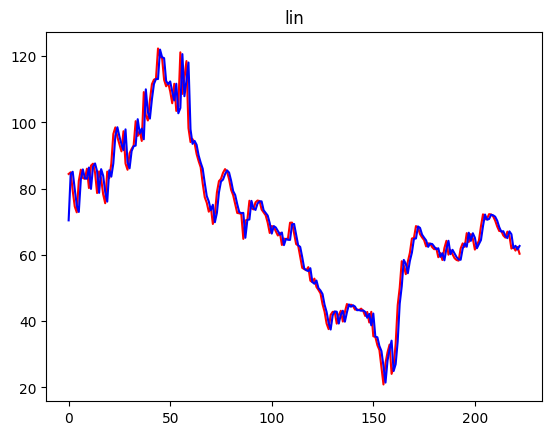

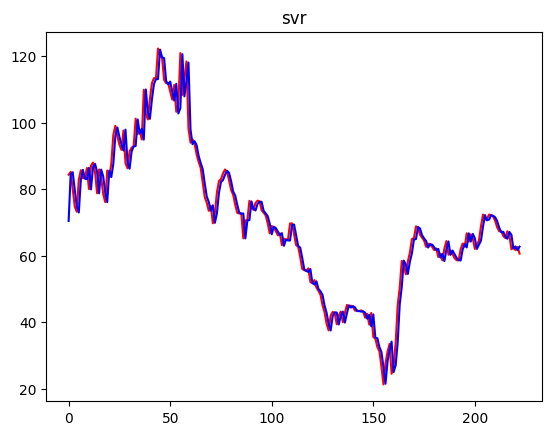

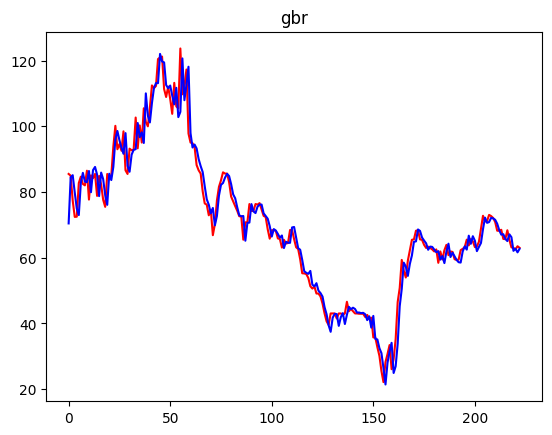

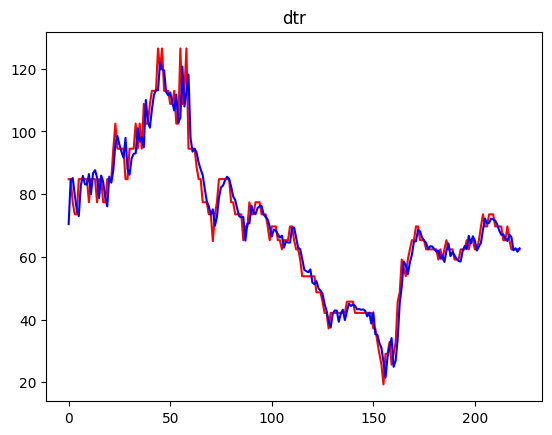

In [36]:
for model in ['lin', 'svr', 'gbr', 'dtr']:
    plt.plot(globals()[f"y_pred_{model}"], 'r')
    plt.plot(globals()[f"y_truth_{model}"], 'b')
    plt.title(model)
    plt.show()

### Step 6: Testing resutls with different amounts of n

In [37]:
def train_test_scaled(n, train_data, test_data):
    
    # Only consider features about previous n weeks and 1 next week of each date
    new_train_data = create_time_series_df(train_data, week_before=n, week_after=1)
    new_test_data = create_time_series_df(test_data, week_before=n, week_after=1)
    
    # Only keep the features of prices of previos weeks and price of the next week of each date
    new_train_data = new_train_data[[column for column in new_train_data.columns if ('Price' in column) == True]]
    new_test_data = new_test_data[[column for column in new_train_data.columns if ('Price' in column) == True]]
    
    new_train_data = new_train_data.fillna(new_train_data.mean())
    new_test_data = new_test_data.fillna(new_test_data.mean())
    
    # Scale the datapoints
    X_train = new_train_data.iloc[:, :-1]
    y_train = new_train_data['Price_t+1']

    X_test = new_test_data.iloc[:, :-1]
    y_test = new_test_data['Price_t+1']

    scaler = StandardScaler()

    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

In [38]:
# !pip install tqdm

In [39]:
from tqdm import tqdm

n_range = list(range(1, 16))

models = {
    'lin': {},
    'svr': {},
    'gbr': {},
    'dtr': {}
}

for n in tqdm(n_range):
    
    X_train_scaled, y_train, X_test_scaled, y_test = train_test_scaled(n, train_data, test_data)
    
    # Train lineaer Regression model for n previous weeks
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Evaluate linear model
    y_pred = model.predict(X_test_scaled)
    y_truth = y_test
    
    models['lin'][n] = {
        'MSE': mean_squared_error(y_pred, y_truth),
        'MAE': mean_absolute_error(y_pred, y_truth)
    }
    
    # Train SVR model for n previous weeks
    model = SVR(C=100, epsilon=0.1, gamma=0.01, kernel='linear')
    model.fit(X_train_scaled, y_train)
    
    # Evaluate SVR model
    y_pred = model.predict(X_test_scaled)
    y_truth = y_test
    
    models['svr'][n] = {
        'MSE': mean_squared_error(y_pred, y_truth),
        'MAE': mean_absolute_error(y_pred, y_truth)
    }
    
    # Train GBR model for n previous weeks
    model = GradientBoostingRegressor()
    model.fit(X_train_scaled, y_train)
    
    # Evaluate GBR model
    y_pred = model.predict(X_test_scaled)
    y_truth = y_test
    
    models['gbr'][n] = {
        'MSE': mean_squared_error(y_pred, y_truth),
        'MAE': mean_absolute_error(y_pred, y_truth)
    }
    
    # Train DTR model for n previous weeks
    model = DecisionTreeRegressor(max_depth= 5, min_samples_leaf= 4, min_samples_split= 3)
    model.fit(X_train_scaled, y_train)
    
    # Evaluate DTR model
    y_pred = model.predict(X_test_scaled)
    y_truth = y_test
    
    models['dtr'][n] = {
        'MSE': mean_squared_error(y_pred, y_truth),
        'MAE': mean_absolute_error(y_pred, y_truth)
    }

100%|██████████| 15/15 [04:14<00:00, 16.98s/it]


In [61]:
models_mse_error = {}
models_mae_error = {}

for k in models:
    for n in models[k]:
        models_mse_error[f"{k}_{n}"] = models[k][n]['MSE']
        models_mae_error[f"{k}_{n}"] = models[k][n]['MAE']

# Sort models based on their MSE and MAE
sorted_mse_error = dict(sorted(models_mse_error.items(), key=lambda item: item[1]))
sorted_mae_error = dict(sorted(models_mae_error.items(), key=lambda item: item[1]))

# lin_8, svr_2, gbr_1, and dtr_1 have the least MSE
# svr_5, lin_5, gbr_1, and dtr_1 have the least MAE
print(sorted_mae_error, '\n')
print(sorted_mse_error, '\n')

# Linear Regression model for the 5 previous weeks gives the best MAE and an aceptable MSE 
models_mse_and_mae_error = {}
for model in models_mse_error.keys():
    models_mse_and_mae_error[model] = models_mae_error[model] + models_mse_error[model]

sorted_mse_and_mae_error = dict(sorted(models_mse_and_mae_error.items(), key=lambda item: item[1]))
print(sorted_mse_and_mae_error)


{'svr_5': 2.920627875466646, 'svr_4': 2.9232409702038162, 'lin_5': 2.9241353612054395, 'svr_3': 2.925217534425263, 'svr_2': 2.926643134527072, 'lin_4': 2.9268313133264376, 'svr_1': 2.9271417766230394, 'lin_7': 2.9327135265129307, 'svr_6': 2.9331446550225357, 'svr_7': 2.933637464683585, 'lin_6': 2.9336599439212785, 'svr_8': 2.9354787631287804, 'lin_8': 2.937049632152545, 'lin_1': 2.942029149729405, 'lin_3': 2.9421880397075855, 'svr_9': 2.948559820657096, 'lin_2': 2.9492478499501353, 'lin_9': 2.9531408491882054, 'lin_10': 2.9542283751349583, 'lin_12': 2.9641699376724584, 'svr_10': 2.964746028391301, 'lin_11': 2.9649107220750457, 'svr_11': 2.9655001293309478, 'svr_13': 2.9673835340442642, 'svr_12': 2.9677528421813135, 'lin_14': 2.96791624992702, 'lin_13': 2.968248694444517, 'svr_14': 2.9715115698135723, 'gbr_1': 2.9722248703631147, 'lin_15': 2.973614261820881, 'svr_15': 2.977398500759725, 'gbr_2': 2.9976454341506646, 'gbr_4': 3.0071530293247206, 'gbr_3': 3.0113438369582957, 'gbr_5': 3.022

### Step 7: Evaluate model based on all other features

In [64]:
# Only consider features about previous 5 weeks and 1 next week of each date
new_train_data = create_time_series_df(train_data, week_before=8, week_after=1)
new_test_data = create_time_series_df(test_data, week_before=8, week_after=1)

# Removing 't' columns from features
new_train_data = new_train_data.iloc[:, 1:]
new_test_data = new_test_data.iloc[:, 1:]

new_train_data = new_train_data.fillna(new_train_data.mean())
new_test_data = new_test_data.fillna(new_test_data.mean())

# Scale the datapoints
X_train = new_train_data.iloc[:, :-1]
y_train = new_train_data['Price_t+1']

X_test = new_test_data.iloc[:, :-1]
y_test = new_test_data['Price_t+1']

scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [69]:
# Train lineaer Regression model for 8 previous weeks
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Evaluate linear model
y_pred = model.predict(X_test_scaled)
y_truth = y_test

print('MSE: ', mean_squared_error(y_pred, y_truth), 'MAE: ', mean_absolute_error(y_pred, y_truth))

MSE:  18.087354673101007 MAE:  2.9910302283870647


### Step 8: Select up to 12 feature using Forward Selection

In [43]:
from sklearn.feature_selection import SequentialFeatureSelector

selector = SequentialFeatureSelector(model,
                                     n_features_to_select=12,
                                     direction='forward')

# selector.fit() has been commented because it will take hell of a time to fit due to our large dataset
# But the results will be used through out this step

# selector.fit(X_train_scaled, y_train)

In [44]:
# selected_feature_indices = selector.get_support(indices=True)

In [45]:
# The output of selector.get_support(indices=True) is:

selected_feature_indices = [0, 6, 7, 8, 9, 11, 13, 14, 17, 23, 27, 29]

In [70]:
# We can do this section with selector.transform() but selector.fit() should run first
X_train_selected = pd.DataFrame()
X_test_selected =  pd.DataFrame()
for index in selected_feature_indices:
    col_name = X_train.columns[index]
    X_train_selected[col_name] = X_train.iloc[:, index]
    X_test_selected[col_name] = X_test.iloc[:, index]

X_train_selected

,Price_t-1,Price_t-2,Open_t-2,High_t-2,Low_t-2,Change %_t-2,Open_t-3,High_t-3,Change %_t-3,Change %_t-4,Low_t-5,Change %_t-5
0,57.06,52.200000,53.49000,55.290000,49.930000,-3.010000,60.25000,61.210000,-10.720000,-2.250000,58.360000,5.040000
1,52.20,53.820000,60.25000,61.210000,52.790000,-10.720000,61.34000,62.330000,-2.250000,5.040000,57.500000,-0.150000
2,53.82,60.280000,61.34000,62.330000,59.330000,-2.250000,59.98000,63.730000,5.040000,-0.150000,58.410000,-11.920000
3,60.28,61.670000,59.98000,63.730000,58.360000,5.040000,58.98000,61.400000,-0.150000,-11.920000,64.610000,-4.870000
4,61.67,58.710000,58.98000,61.400000,57.500000,-0.150000,66.99000,67.640000,-11.920000,-4.870000,69.130000,-3.640000
...,...,...,...,...,...,...,...,...,...,...,...,...
1338,18.60,19.190000,19.25000,19.300000,18.960000,0.210000,18.98000,19.240000,1.270000,0.530000,18.730000,0.210000
1339,19.19,19.150000,18.98000,19.240000,18.720000,1.270000,18.82000,18.980000,0.530000,0.210000,50.907812,0.190388
1340,19.15,18.910000,18.82000,18.980000,18.710000,0.530000,18.98000,19.030000,0.210000,0.188567,50.907812,0.190388
1341,18.91,18.810000,18.98000,19.030000,18.730000,0.210000,52.60475,54.153065,0.180433,0.188567,50.907812,0.190388


In [71]:
# Scale the datapoints
scaler = StandardScaler()
scaler.fit(X_train_selected)
X_train_scaled = scaler.transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Train lineaer Regression model for 8 previous weeks
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Evaluate linear model
y_pred = model.predict(X_test_scaled)
y_truth = y_test

print('MSE: ', mean_squared_error(y_pred, y_truth), 'MAE: ', mean_absolute_error(y_pred, y_truth))

MSE:  17.697667568136673 MAE:  2.931092898858226


### Step 9: Predict the price of following 4 weeks based on past 12 weeks

In [48]:
# Only consider features about previous 12 weeks and 4 next week of each date
new_train_data = create_time_series_df(train_data, week_before=12, week_after=4)
new_test_data = create_time_series_df(test_data, week_before=12, week_after=4)

# Removing 't' columns from features
new_train_data = new_train_data.iloc[:, 1:]
new_test_data = new_test_data.iloc[:, 1:]

new_train_data = new_train_data.fillna(new_train_data.mean())
new_test_data = new_test_data.fillna(new_test_data.mean())

# Scale the datapoints
X_train = new_train_data.iloc[:, :-4]
y_train = new_train_data.iloc[:, -4:]

X_test = new_test_data.iloc[:, :-4]
y_test = new_test_data.iloc[:, -4:]

scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
# Train a lineaer Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Evaluate the lineaer Regression model
y_pred_lin = model.predict(X_test_scaled)
y_truth_lin = y_test

print('MSE:', mean_squared_error(y_pred_lin, y_truth_lin), '\nMAE:', mean_absolute_error(y_pred_lin, y_truth_lin))

MSE: 38.82128384247388 
MAE: 4.52527709689655


In [50]:
# Finding best SVR parameters by suing GridSearchCV
svr = SVR()

'''
parameters = {
    'kernel': ('linear', 'rbf','poly'),
    'C':[1, 10, 100],
    'gamma': [1e-2, 0.1, 0.4, 0.8],
    'epsilon':[1e-2, 0.1, 0.4, 0.8]
}
'''

# After using GridSearchCV, the best parameters are:
# {'C': 10, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'linear'}


# models = []
# for i in range(4):
#     y_train_target = y_train.iloc[:, i]
#     y_train_target_1d = y_train_target.values.flatten()

#     best_svr = GridSearchCV(svr, parameters, cv=3, verbose=10, n_jobs=-1)
#     best_svr.fit(X_train, y_train_target_1d)
#     models.append(best_svr)

"\nparameters = {\n    'kernel': ('linear', 'rbf','poly'),\n    'C':[1, 10, 100],\n    'gamma': [1e-2, 0.1, 0.4, 0.8],\n    'epsilon':[1e-2, 0.1, 0.4, 0.8]\n}\n"

In [51]:
best_params_ = {'C': 10, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'linear'}

# Define an SVR model with the best hyperparameters
model = SVR(
    C=best_params_['C'], 
    epsilon=best_params_['epsilon'], 
    gamma=best_params_['gamma'], 
    kernel=best_params_['kernel']
)

# Train the SVR model for each target variable and Make predictions for each target variable
predictions = []
for i in range(4):
    y_train_target = y_train.iloc[:, i]
    y_train_target_1d = y_train_target.values.flatten()
    
    model.fit(X_train_scaled, y_train_target_1d)

    y_test_target = y_test.iloc[:, i]
    y_test_target_1d = y_test_target.values.flatten()
    
    prediction = model.predict(X_test_scaled)
    predictions.append(prediction)


y_pred_svr = pd.DataFrame(np.array(predictions).T, columns=y_test.columns)
y_truth_svr = y_test

print('MSE:', mean_squared_error(y_pred_svr, y_truth_svr), '\nMAE:', mean_absolute_error(y_pred_svr, y_truth_svr))

MSE: 38.83177325044287 
MAE: 4.521931621645259


In [52]:
# Finding best GBR parameters by suing GridSearchCV
gbr = GradientBoostingRegressor()

'''
parameters = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
'''

# After using GridSearchCV, the best parameters are:
# {'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 1000}
# but the default numbers fot parameters gives a lower ERROR

# models = []
# for i in range(4):
#     y_train_target = y_train.iloc[:, i]
#     y_train_target_1d = y_train_target.values.flatten()

#     best_gbr = GridSearchCV(gbr, parameters, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'], cv=3, verbose=10, n_jobs=-1, refit=False)
#     best_gbr.fit(X_train, y_train_target_1d)
#     models.append(best_gbr)


"\nparameters = {\n    'max_depth': [80, 90, 100, 110],\n    'max_features': [2, 3],\n    'min_samples_leaf': [3, 4, 5],\n    'min_samples_split': [8, 10, 12],\n    'n_estimators': [100, 200, 300, 1000]\n}\n"

In [53]:
best_params_ = {'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 1000}

# Define an GBR model with the best hyperparameters
model = GradientBoostingRegressor(
    max_depth=best_params_['max_depth'],
    max_features=best_params_['max_features'],
    min_samples_leaf=best_params_['min_samples_leaf'],
    min_samples_split=best_params_['min_samples_split'],
    n_estimators=best_params_['n_estimators']
)

# Train the GBR model for each target variable and Make predictions for each target variable
predictions = []
for i in range(4):
    y_train_target = y_train.iloc[:, i]
    y_train_target_1d = y_train_target.values.flatten()
    
    model.fit(X_train_scaled, y_train_target_1d)

    y_test_target = y_test.iloc[:, i]
    y_test_target_1d = y_test_target.values.flatten()
    
    prediction = model.predict(X_test_scaled)
    predictions.append(prediction)


y_pred_gbr = pd.DataFrame(np.array(predictions).T, columns=y_test.columns)
y_truth_gbr = y_test

print('MSE:', mean_squared_error(y_pred_gbr, y_truth_gbr), '\nMAE:', mean_absolute_error(y_pred_gbr, y_truth_gbr))


MSE: 56.52735627513957 
MAE: 5.655309537091849


In [54]:
# Finding best DTR parameters by suing GridSearchCV
dtr = DecisionTreeRegressor()

'''
parameters = {
    'max_depth': list(range(1, 6)),
    'min_samples_leaf': list(range(2, 6)),
    'min_samples_split': list(range(1, 6))
}
'''

# After using GridSearchCV, the best parameters are:
# {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 4}

# models = []
# for i in range(4):
#     y_train_target = y_train.iloc[:, i]
#     y_train_target_1d = y_train_target.values.flatten()

#     best_dtr = GridSearchCV(dtr, parameters, scoring='neg_mean_absolute_error', cv=9, verbose=10, n_jobs=-1)
#     best_dtr.fit(X_train, y_train_target_1d)
#     models.append(best_dtr)

"\nparameters = {\n    'max_depth': list(range(1, 6)),\n    'min_samples_leaf': list(range(2, 6)),\n    'min_samples_split': list(range(1, 6))\n}\n"

In [55]:
best_params_ = {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 4}

# Define a DecisionTreeRegressor model with the best hyperparameters
model = DecisionTreeRegressor(
    max_depth= best_params_['max_depth'],
    min_samples_leaf= best_params_['min_samples_leaf'],
    min_samples_split= best_params_['min_samples_split']
)

# Train the DecisionTreeRegressor model for each target variable and Make predictions for each target variable
predictions = []
for i in range(4):
    y_train_target = y_train.iloc[:, i]
    y_train_target_1d = y_train_target.values.flatten()
    
    model.fit(X_train_scaled, y_train_target_1d)

    y_test_target = y_test.iloc[:, i]
    y_test_target_1d = y_test_target.values.flatten()
    
    prediction = model.predict(X_test_scaled)
    predictions.append(prediction)


y_pred_dtr = pd.DataFrame(np.array(predictions).T, columns=y_test.columns)
y_truth_dtr = y_test

print('MSE:', mean_squared_error(y_pred_dtr, y_truth_dtr), '\nMAE:', mean_absolute_error(y_pred_dtr, y_truth_dtr))

MSE: 50.224855143822325 
MAE: 5.2436220054975475


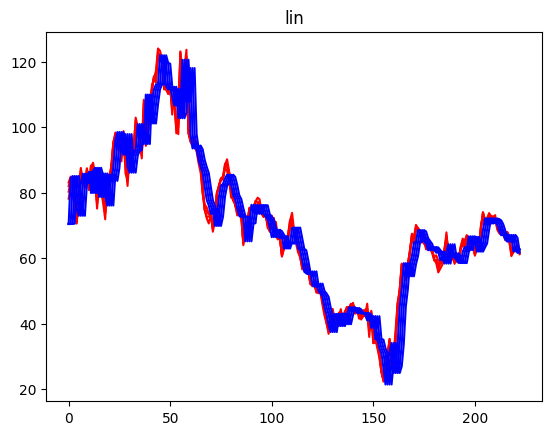

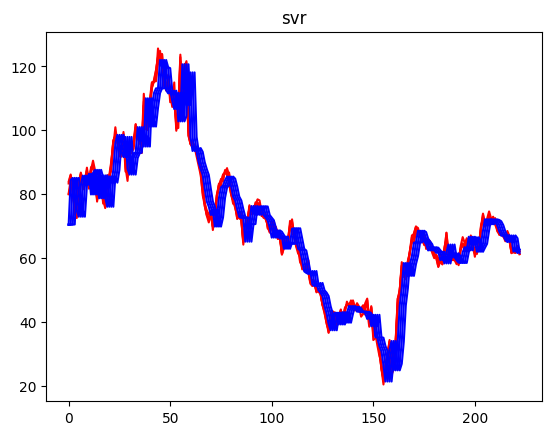

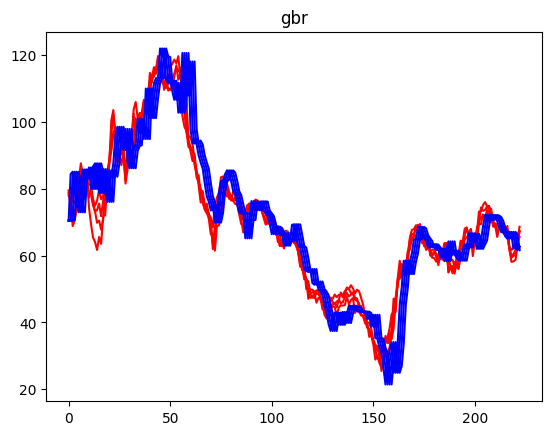

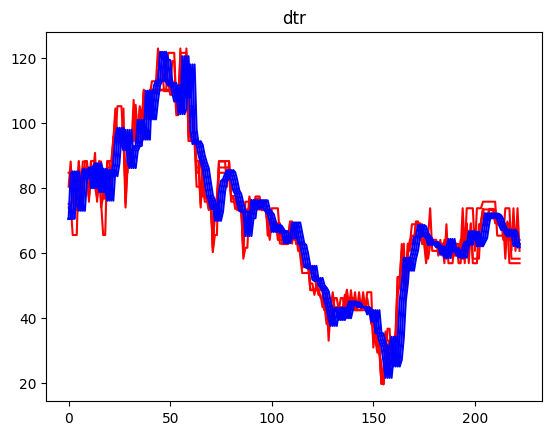

In [56]:
for model in ['lin', 'svr', 'gbr', 'dtr']:
    plt.plot(globals()[f"y_pred_{model}"], 'r')
    plt.plot(globals()[f"y_truth_{model}"], 'b')
    plt.title(model)
    plt.show()